# COLX 531 Lab 1. Machine Translation with Huggingface Transformers

You can find the annotated version of this code [here](https://huggingface.co/learn/nlp-course/en/chapter7/4). Please make extensive use of the public documentation to understand what this notebook does.

Instructions:
1. Register for an account on [HuggingFace](https://huggingface.co/);
2. Register for an account on [Weights & Biases](https://wandb.ai/site);
3. Run the training code below. You need to train two models. The first model is initialized randomly. The other model is initialized with pretrained weights. You are asked to log the whole training process with W&B. Each run takes about 2 hours. Please do not change the code except for a few lines related to model initialization and logging.
4. When you submit, **please also submit a pdf version of your notebook**.

### Assignment 1.1
rubric={accuracy:5}

After completing model training, push the trained model to HuggingFace hub under your own account. Please paste the link to your trained model below. The name of your model should be: **your_username/lab1_finetuning** and **your_username/lab1_random** for the randomly initialized model and the finetuned model respectively.

**Note**. you must make the model public. Ohterwise we cannot grade your answer. If we cannot access your model page during grading, we will assign 0 to this question. In that case, a screenshot will be taken as evidence.

https://huggingface.co/yiwenxxc/lab1_finetuning \

https://huggingface.co/yiwenxxc/lab1_random/settings
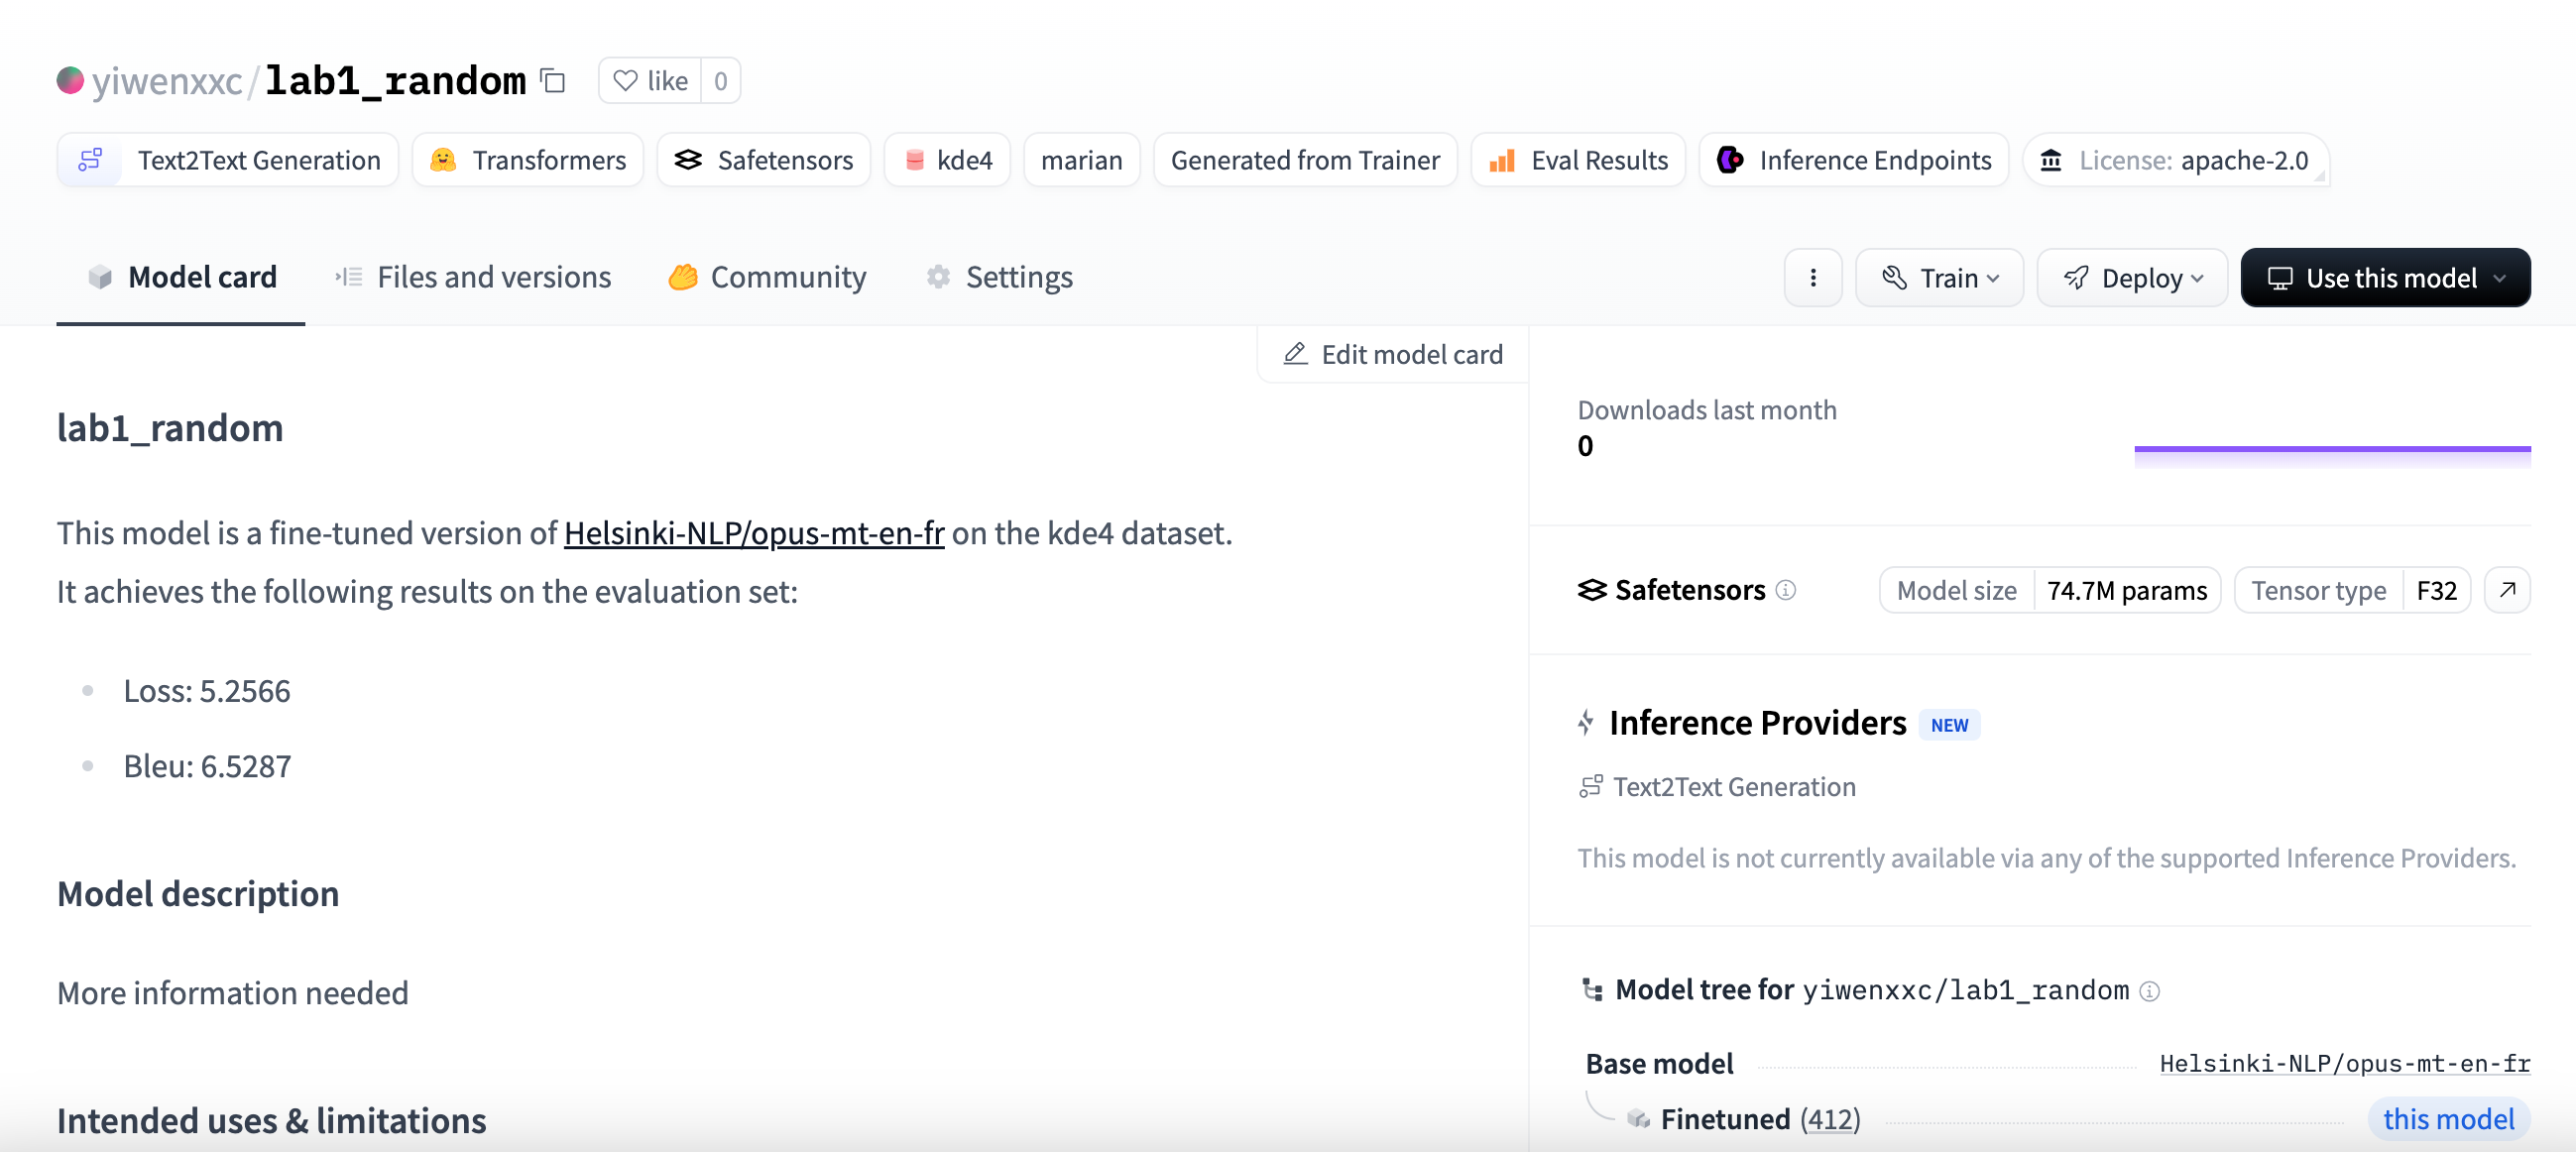
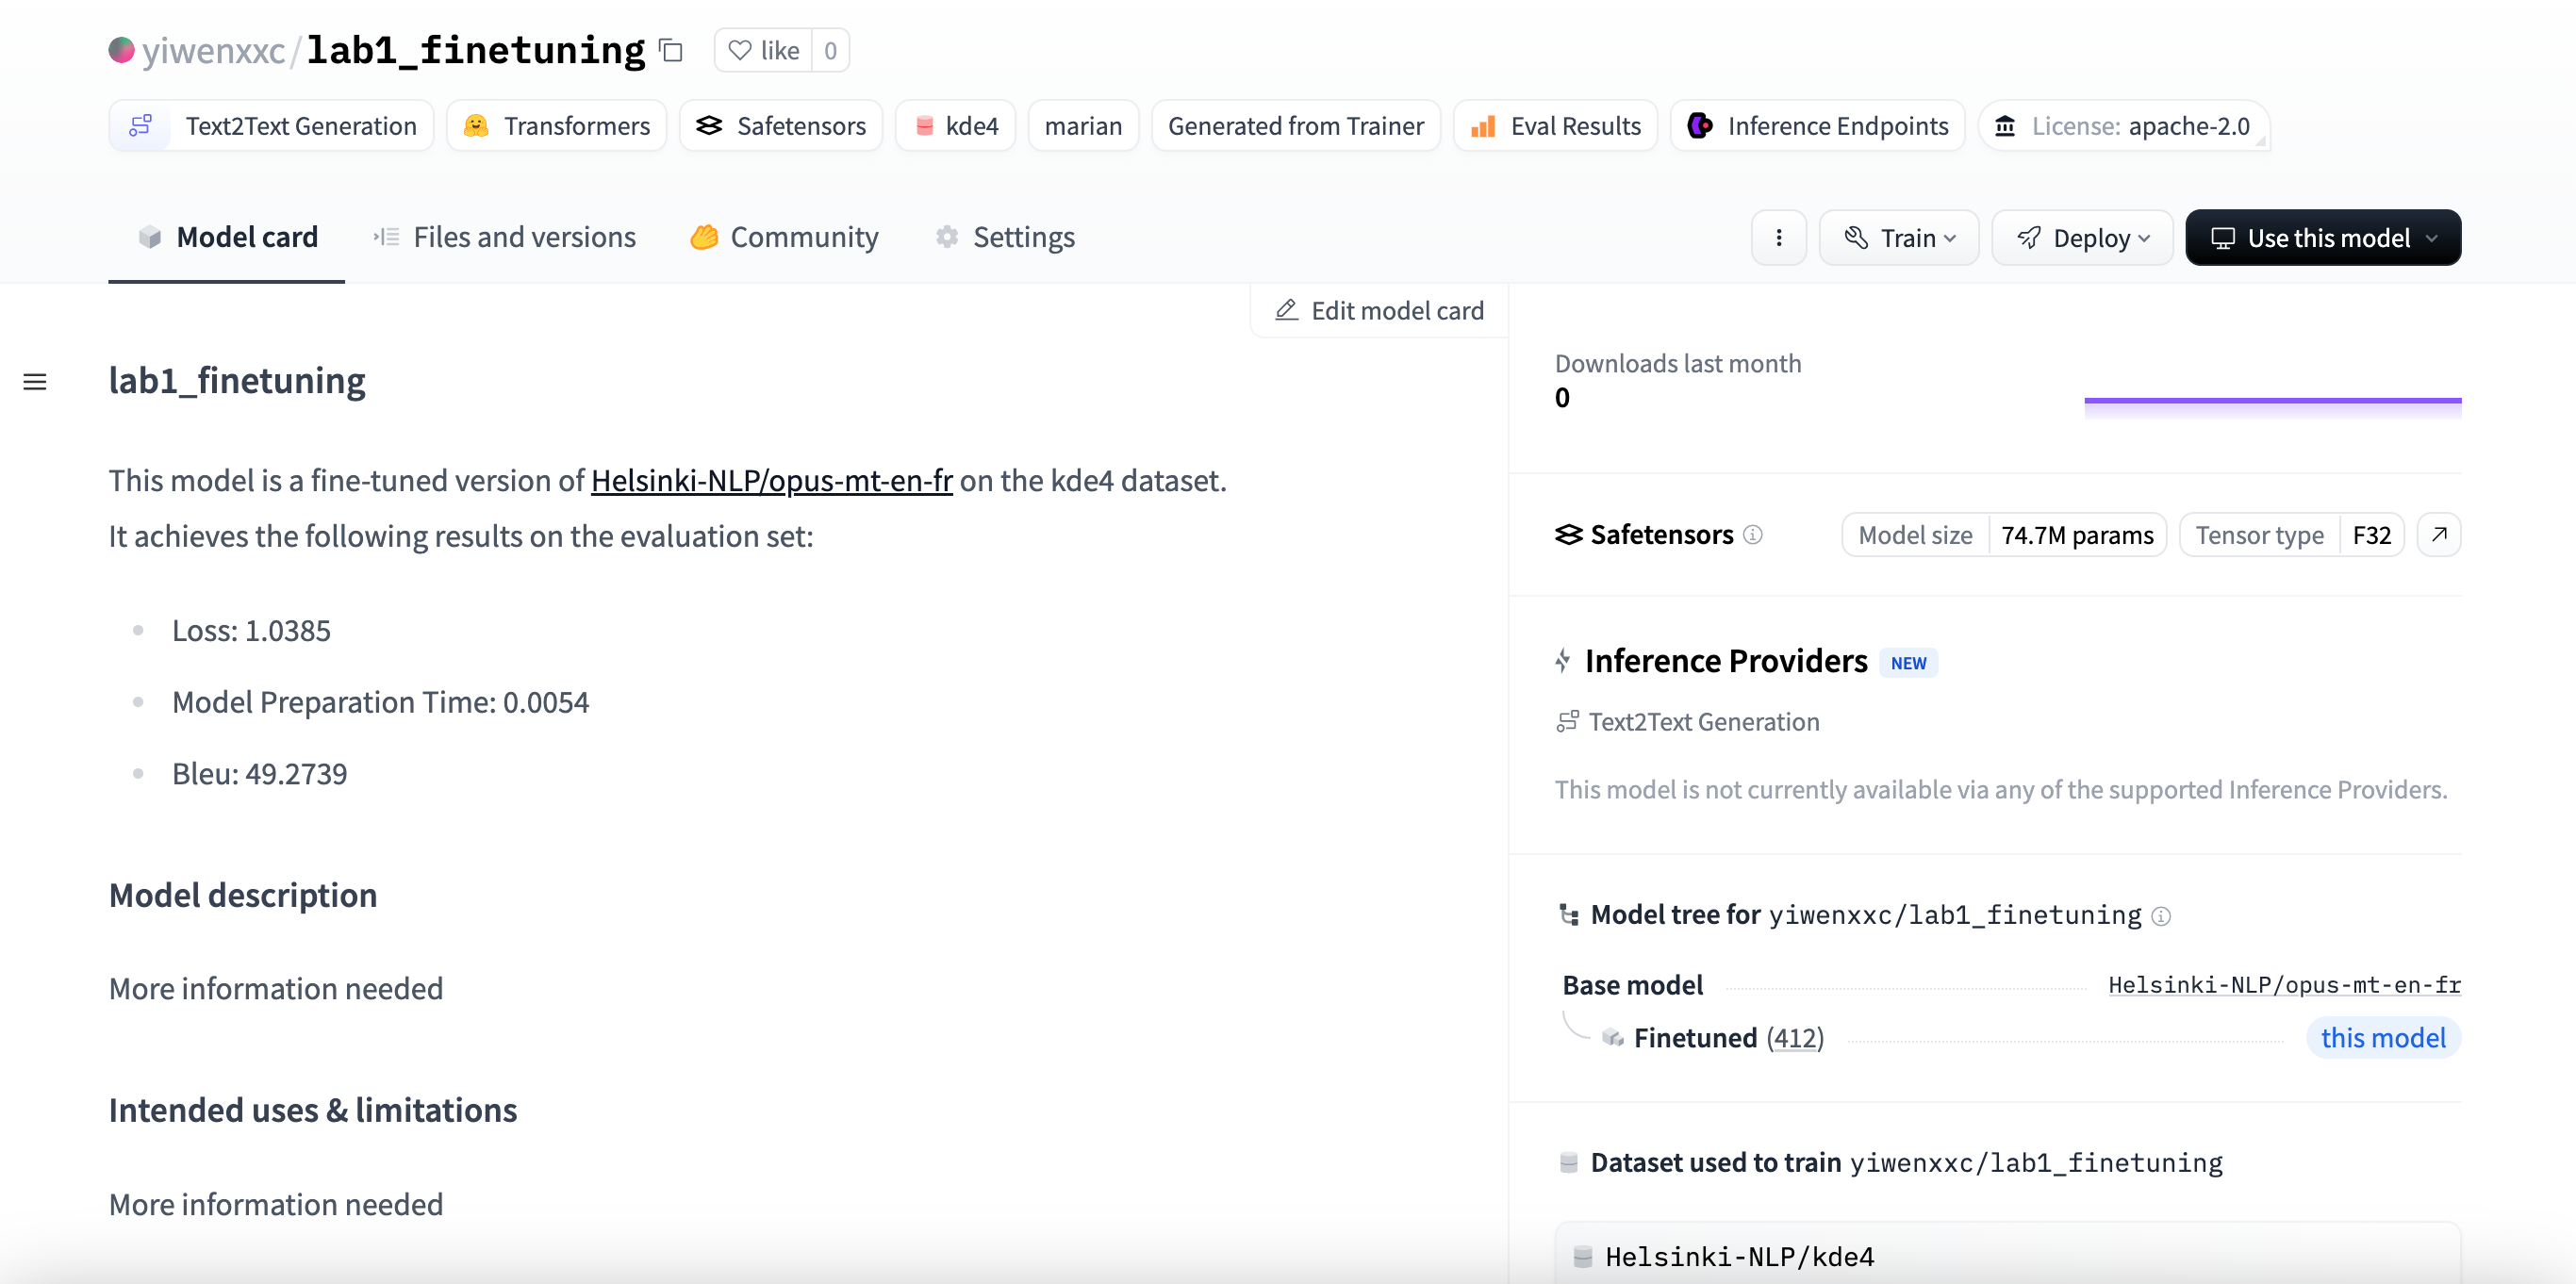


### Assignment 1.2
rubric={accuracy:5}

During model training, sync training statistics to your Weights & Biases page under your own account. Please paste the link to your W&B page to this model. You should use **COLX531** as the project name and **lab1_random** / **lab1_finetuning** as the run names for two models respectively.

**Note**. you must make this W&B page public **and** upload a screenshot of your W&B page. Ohterwise we cannot grade your answer. If we cannot access your W&B page during grading, we will assign 0 to this question. In that case, a screenshot will be taken as evidence.

https://wandb.ai/tiffanychen020514-university-of-british-columbia/COLX531/runs/kfkb57vb/overview \
https://wandb.ai/tiffanychen020514-university-of-british-columbia/COLX531/runs/n5ddkkyk/overview
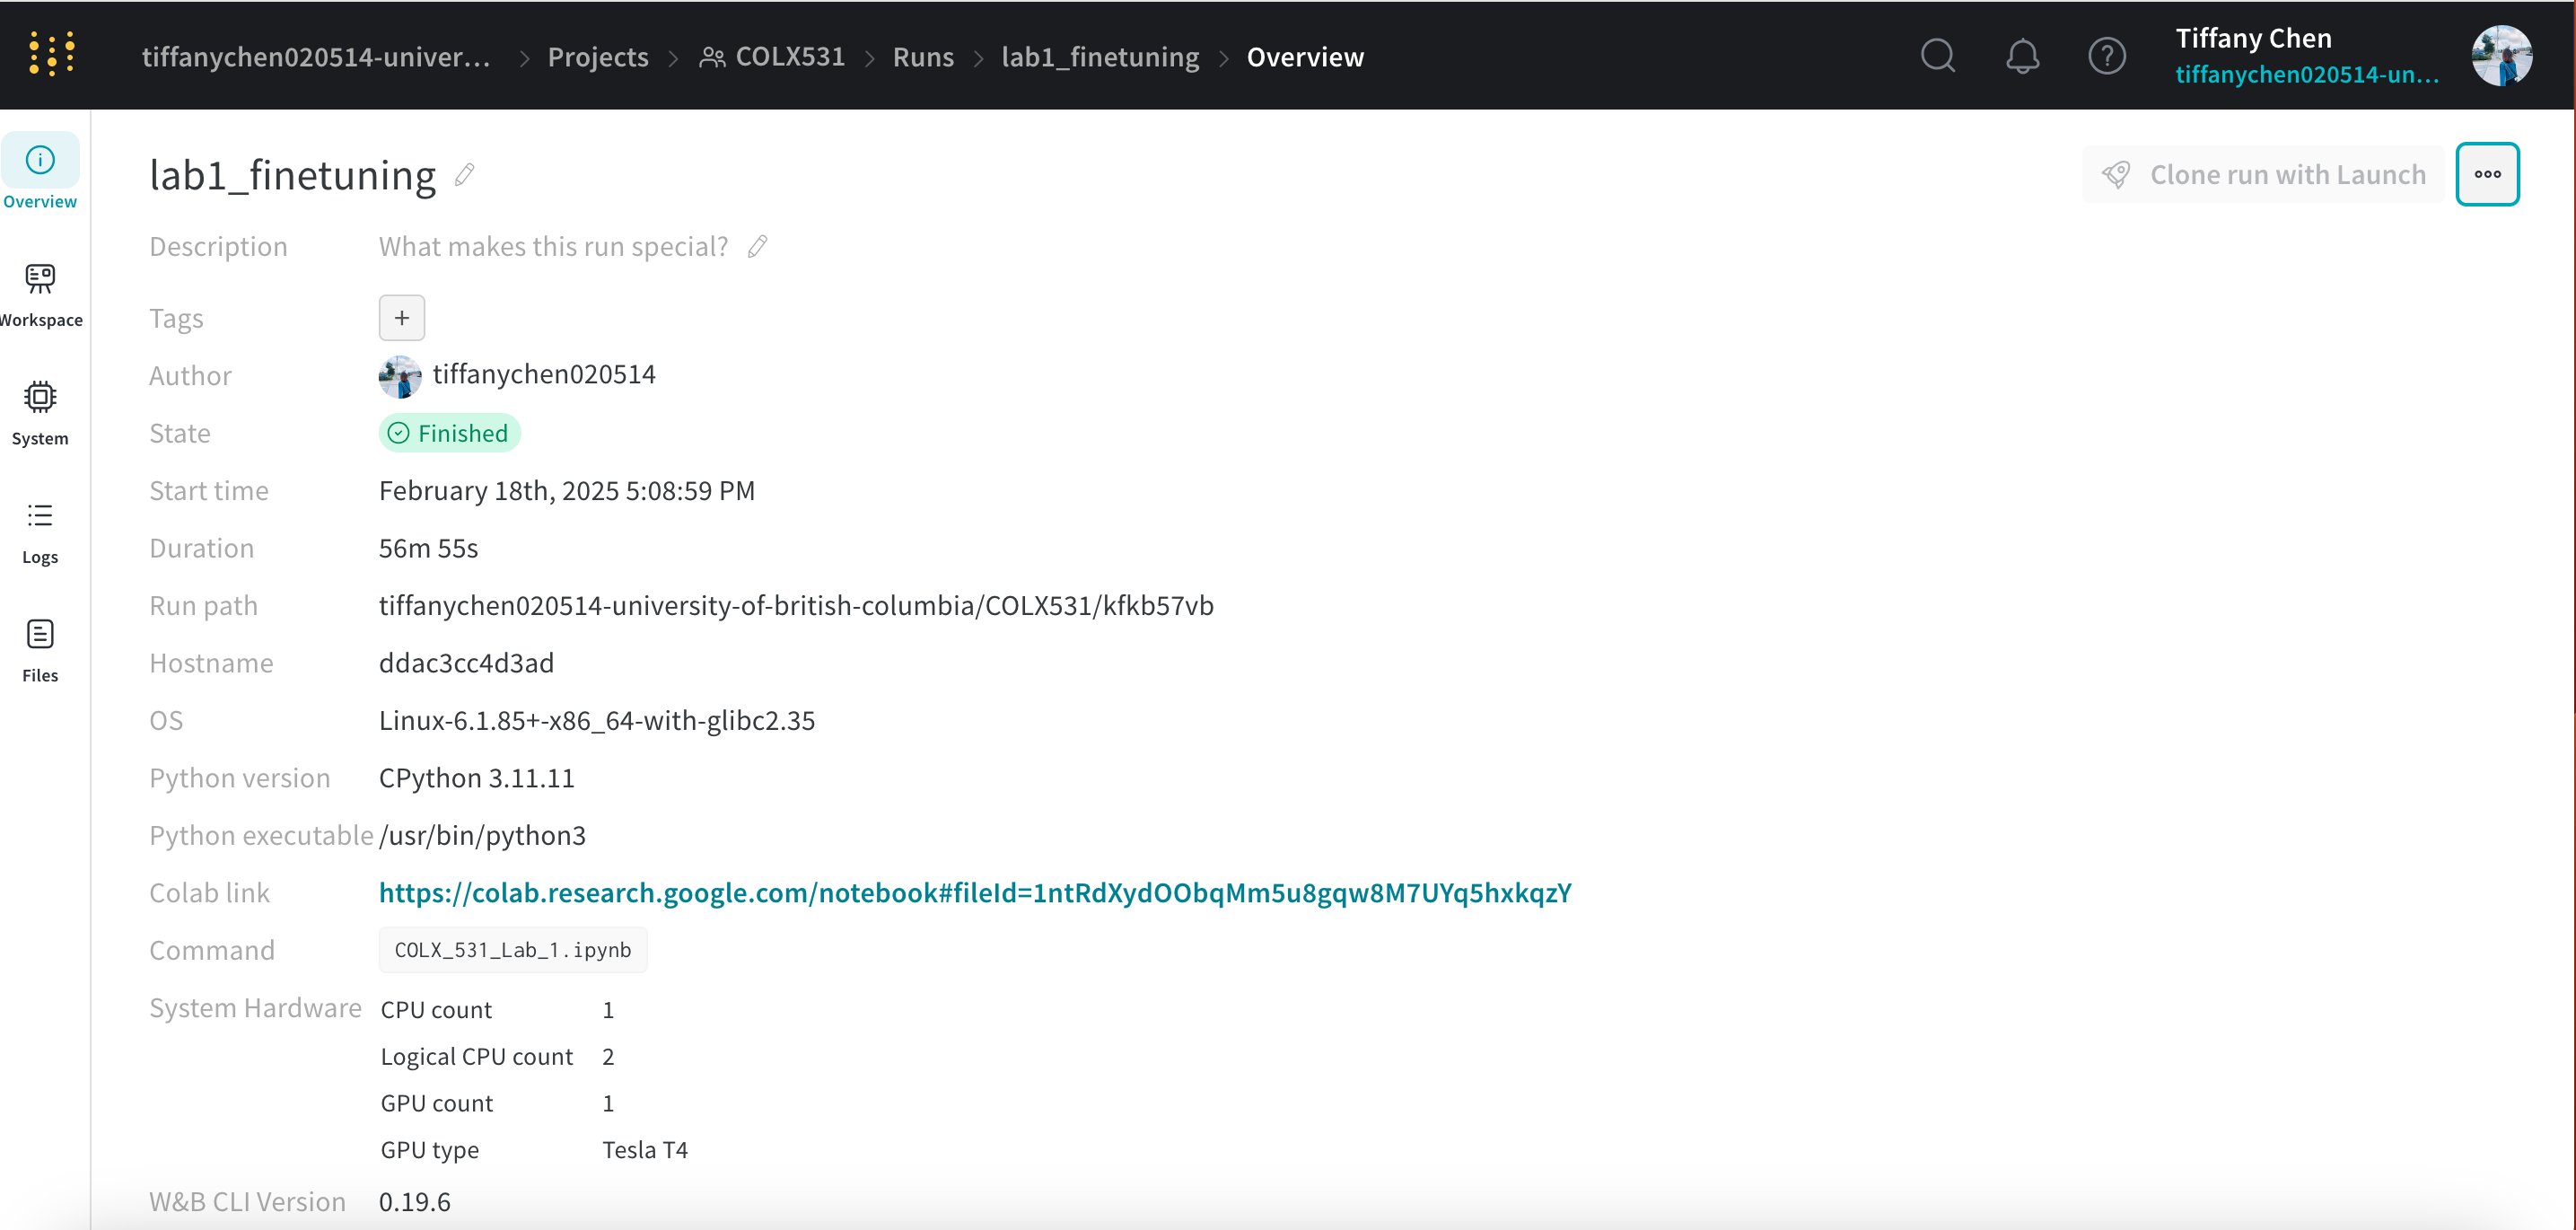
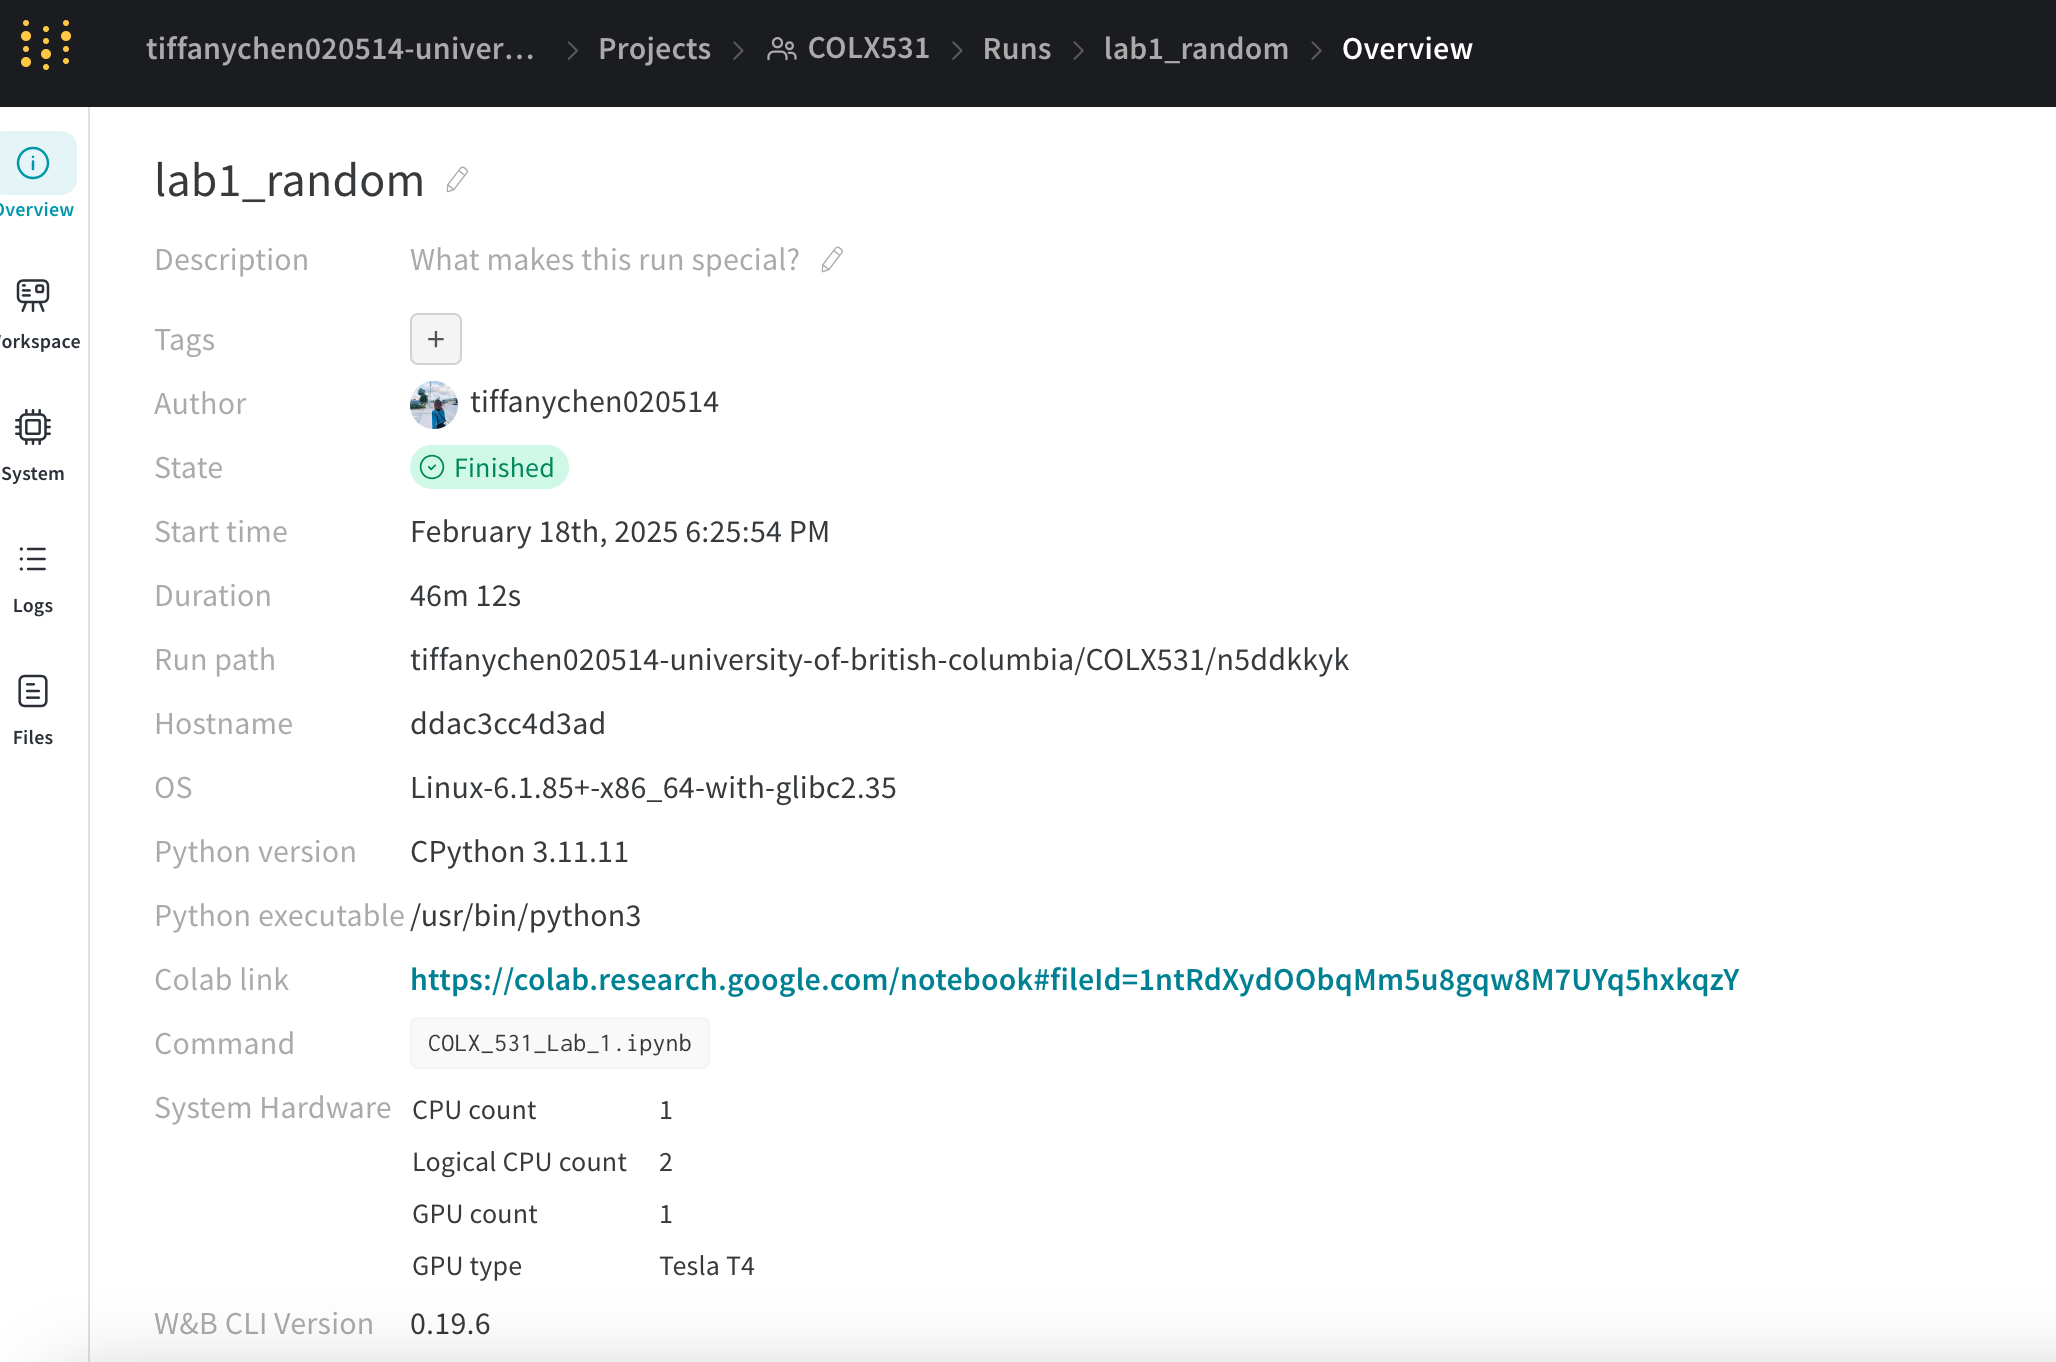

### Assignment 1.3
rubric={accuracy:10}

Add a comment at **each code block** to explain what that block does. Comments must be **your own words**. Your comments should follow this format: # Comment: your explanations


### Assignment 1.4
rubric={accuracy:10}

Please answer the following questions **in your own words**. Ansers that are copied from existing sources without paraphrasing will not be graded.




1. What is `bleu` score? How is it calculated?
- The BLEU score is a metric used to evaluate the quality of machine translation models by comparing generated translations with reference translations. It calculates how many words or phrases from the generated text appear in the reference translation. And the precision is served as the main measure. It is calculated using n-gram precision, applying a brevity penalty to avoid favoring short translations.
2. What is the role of a data collator in this notebook?
- It is responsible for grouping multiple training examples into batches and ensuring they are the same length. It does this by tokenizing the input and target texts and adding padding to shorter sequences so they match the longest sentence in the batch. 
3. How much memory on average does evaluating a MT model cost in this notebook? (Inspect your W&B page).
-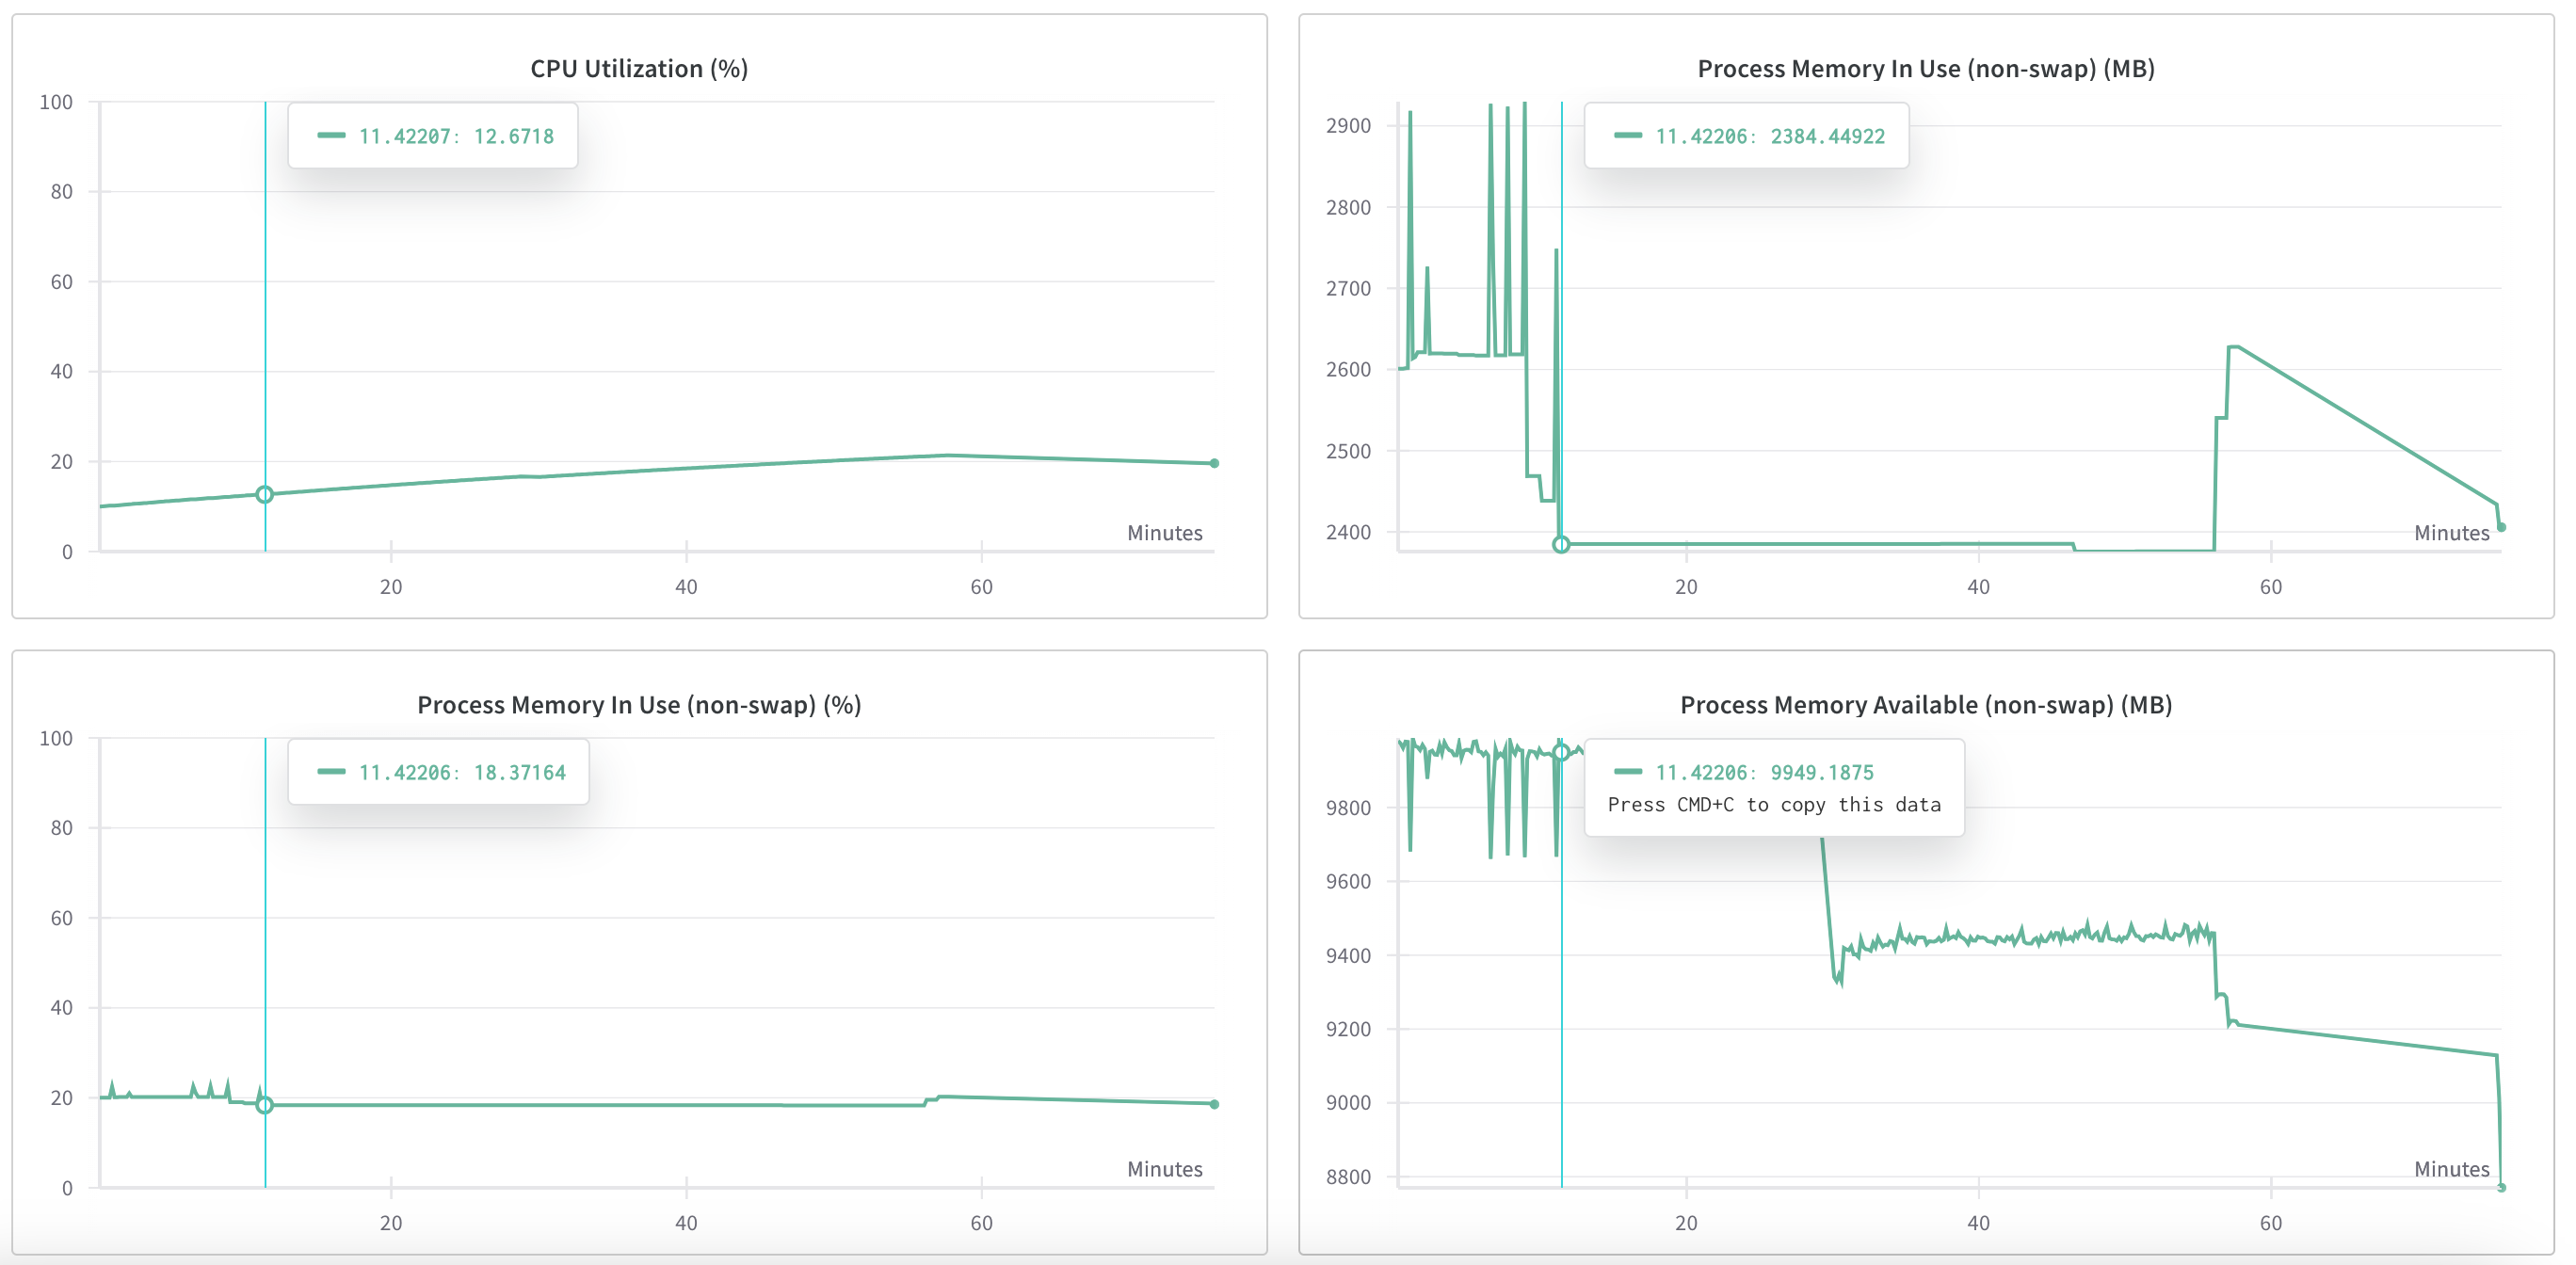
4. How much memory on average does training a MT model cost in this notebook? (Inspect your W&B page).
-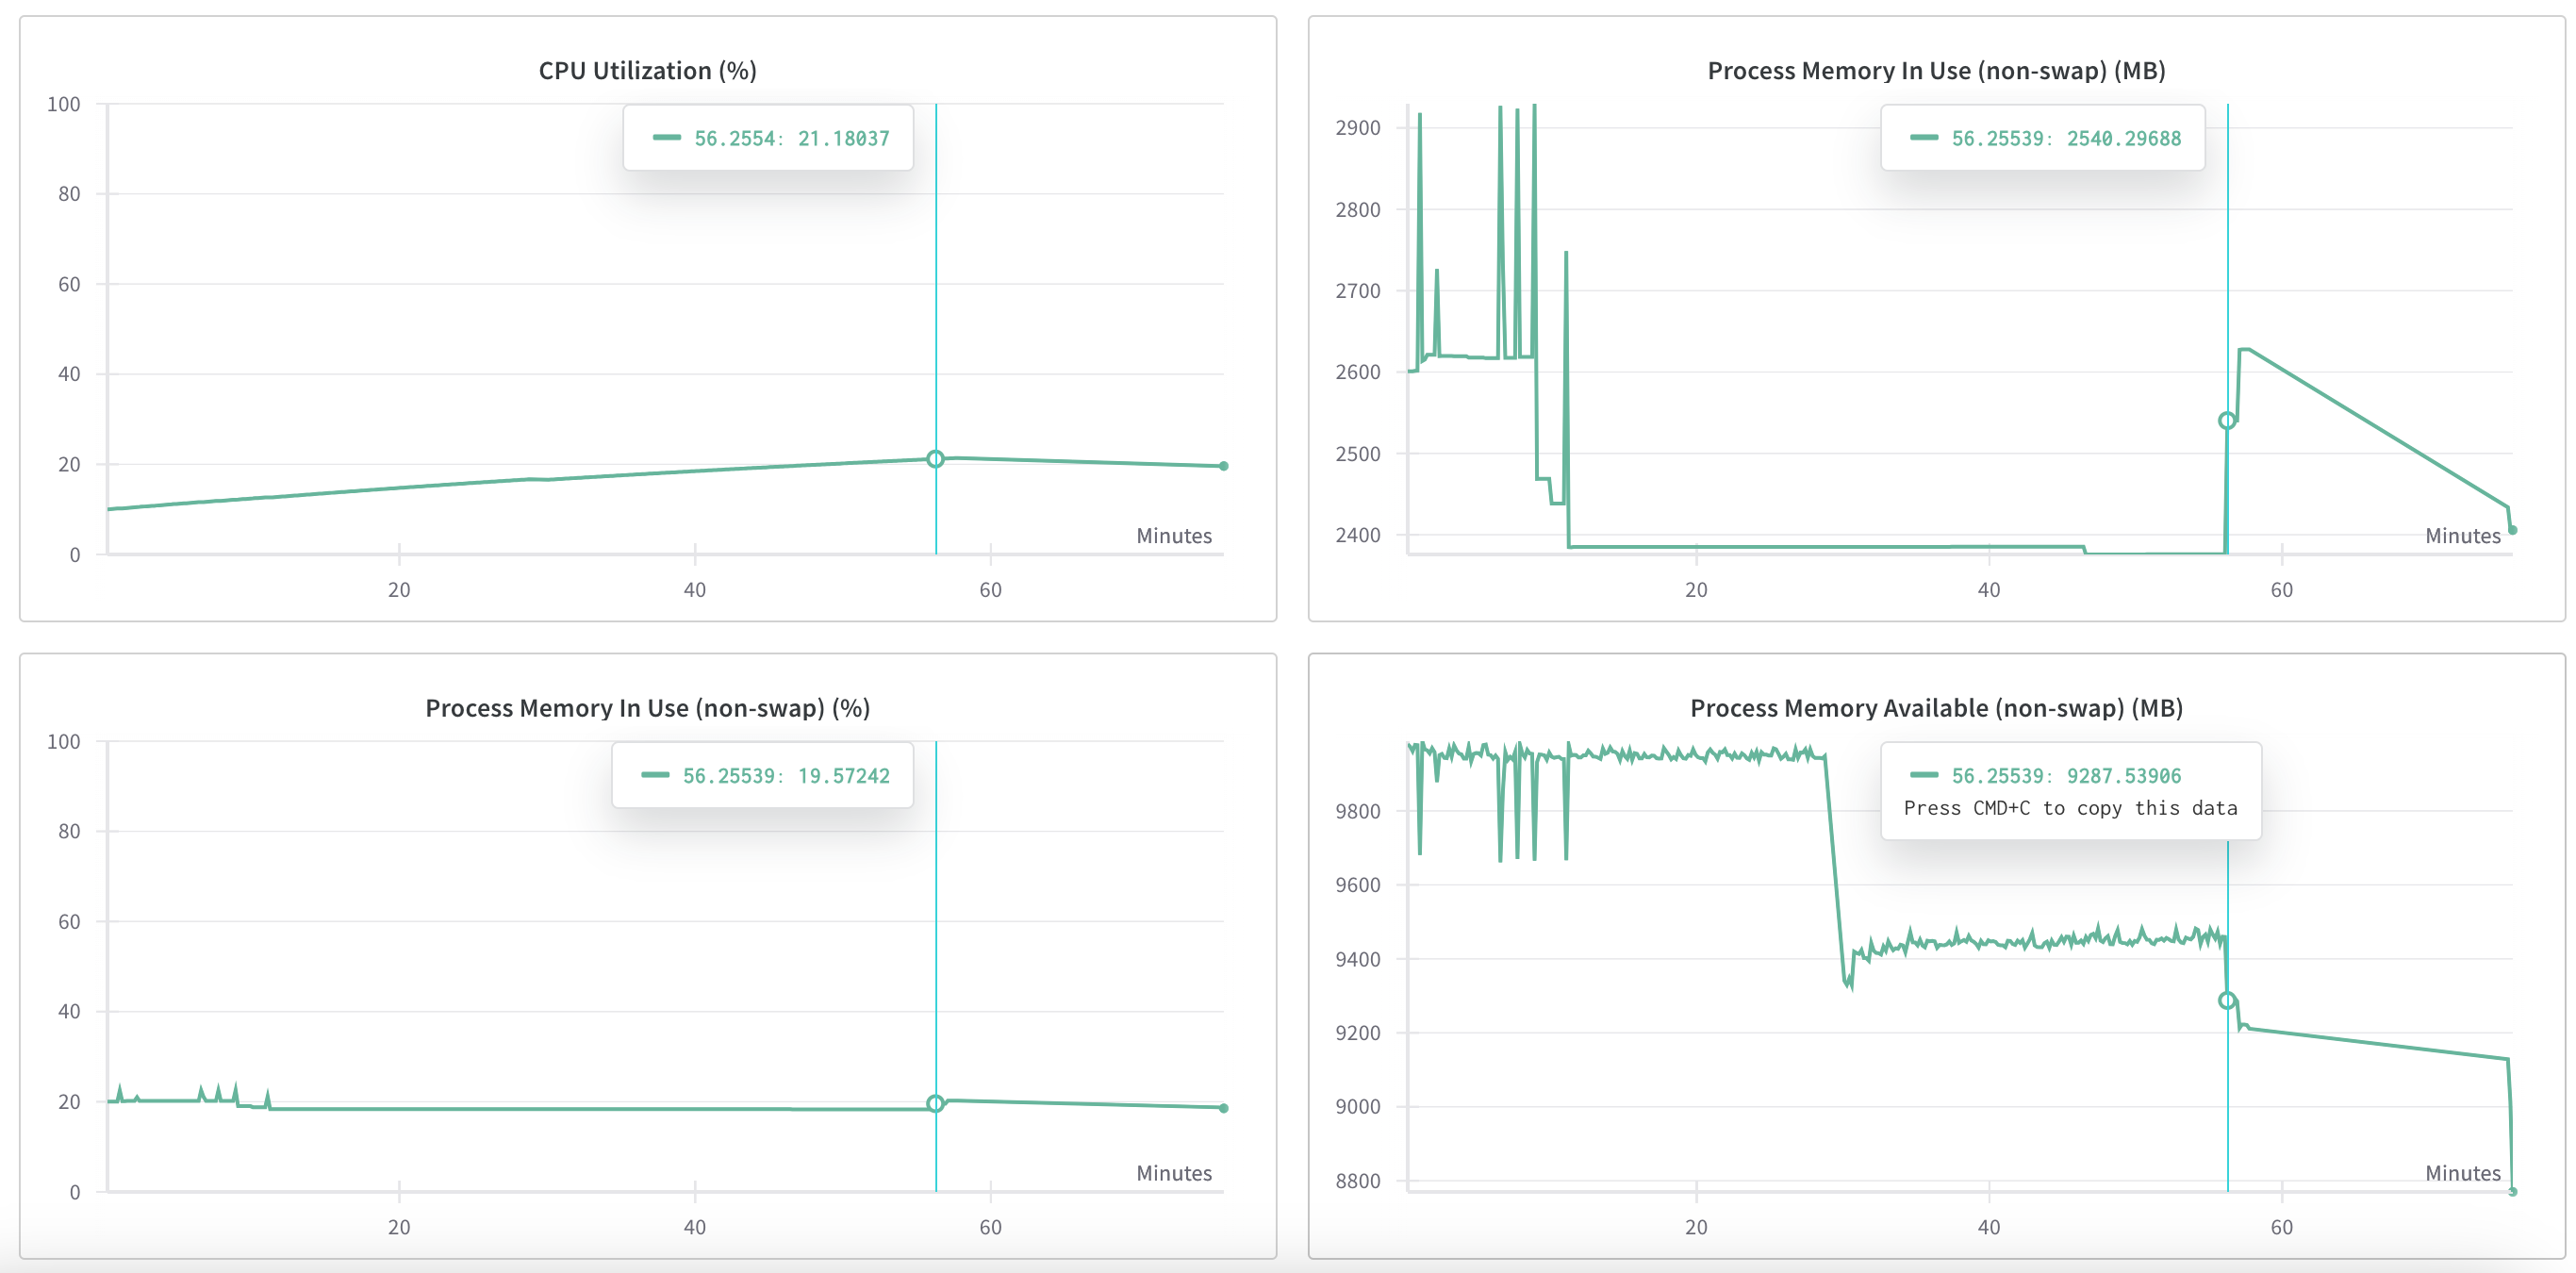
5. Describe the differences (if any) in terms of loss, evaluation results, training speed and memory usage between a randomly initialized model and a finetuned model initialized with pretrained weights. (Inspect your W&B page).
- The fine-tuned model has a much lower training loss of 1.12 and evaluation loss of 1.03, while the randomly initialized model has significantly higher losses, with 5.33 for training and 5.25 for evaluation. This shows that the pretrained model learns faster and reaches better performance in fewer steps. The BLEU score for the fine-tuned model is 49.2, meaning its translations are much closer to the reference texts, while the randomly initialized model only achieves 6.52, indicating poor translation quality. In terms of training speed, the fine-tuned model processes more samples per second compared to the randomly initialized one, and it also completes more training steps per second. This suggests that the pretrained model is more efficient since it starts with existing knowledge rather than learning everything from scratch. Memory usage remains similar between both models because they share the same architecture and batch size. 



Install the wandb, Transformers, Datasets, and Evaluate libraries to run this notebook.

In [ ]:
# Install the wandb, Transformers, Datasets, and Evaluate libraries  (your comment should look like this)
!pip install datasets evaluate transformers[sentencepiece]
!pip install accelerate
!pip install wandb
# To run the training on TPU, you will need to uncomment the following line:
# !pip install cloud-tpu-client==0.10 torch==1.9.0 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
!apt install git-lfs

You will need to setup git, adapt your email and name in the following cell.

You will also need to be logged in to the Hugging Face Hub. Execute the following and enter your credentials.

In [ ]:
# log in to your own HuggingFace account
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
# log in to your own wandb account
import wandb
wandb.login(key='ab40927d7ff45aebac010a97159be0d887c9feb2')

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
from datasets import load_dataset

raw_datasets = load_dataset("kde4", lang1="en", lang2="fr") # kde4 is dataset identifier, en =  English, fr = French

In [ ]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 210173
    })
})

In [ ]:
split_datasets = raw_datasets["train"].train_test_split(train_size=0.9, seed=20) #Split the training dataset into two parts, 90% for training and 10% for validation. Seed is set to 20 to make sure the split is same every time we run the code.
split_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 189155
    })
    test: Dataset({
        features: ['id', 'translation'],
        num_rows: 21018
    })
})

In [ ]:
split_datasets["validation"] = split_datasets.pop("test") # Rename the "test" split to "validation"

In [ ]:
split_datasets["train"][1]["translation"] #Get the second example from the training dataset and retrieve its "translation"

{'en': 'Default to expanded threads',
 'fr': 'Par défaut, développer les fils de discussion'}

In [ ]:
from transformers import pipeline

model_checkpoint = "Helsinki-NLP/opus-mt-en-fr" # Define the model checkpoint which is for English-to-French translation model from Helsinki-NLP.
translator = pipeline("translation", model=model_checkpoint) # Create a translation pipeline using the model checkpoint defined above.
translator("Default to expanded threads") # Translate given sentence into French

Device set to use cuda:0


[{'translation_text': 'Par défaut pour les threads élargis'}]

In [ ]:
split_datasets["train"][172]["translation"] # #Get the 173rd example from the training dataset and retrieve its "translation"

{'en': 'Unable to import %1 using the OFX importer plugin. This file is not the correct format.',
 'fr': "Impossible d'importer %1 en utilisant le module d'extension d'importation OFX. Ce fichier n'a pas un format correct."}

In [ ]:
translator(
    "Unable to import %1 using the OFX importer plugin. This file is not the correct format."
)
# # Translate given sentence into French

[{'translation_text': "Impossible d'importer %1 en utilisant le plugin d'importateur OFX. Ce fichier n'est pas le bon format."}]

In [ ]:
from transformers import AutoTokenizer

model_checkpoint = "Helsinki-NLP/opus-mt-en-fr" # Define the model checkpoint which is for English-to-French translation model from Helsinki-NLP.
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, return_tensors="pt") # Load the tokenizer using the model checkpoint defined above. The 'return_tensors="pt"' argument ensures the tokens are returned as PyTorch tensors.

In [ ]:
en_sentence = split_datasets["train"][1]["translation"]["en"] # Get english translation of second example from the training dataset
fr_sentence = split_datasets["train"][1]["translation"]["fr"] # Get french translation of second example from the training dataset

inputs = tokenizer(en_sentence, text_target=fr_sentence) # Tokenize both the English input sentence and the French target sentence, 'text_target' specifies the reference translation
inputs # show tokenized output

{'input_ids': [47591, 12, 9842, 19634, 9, 0], 'attention_mask': [1, 1, 1, 1, 1, 1], 'labels': [577, 5891, 2, 3184, 16, 2542, 5, 1710, 0]}

In [ ]:
wrong_targets = tokenizer(fr_sentence) # Tokenize only the French sentence without specifying it as a target
print(tokenizer.convert_ids_to_tokens(wrong_targets["input_ids"])) # Convert the tokenized input IDs into their corresponding tokens and print them.
print(tokenizer.convert_ids_to_tokens(inputs["labels"])) # Convert the correctly tokenized target labels into tokens and print them.

In [ ]:
max_length = 128 # Define the maximum sequence length for tokenization is 128


def preprocess_function(examples): # Define a function to preprocess a batch of examples for training.
    inputs = [ex["en"] for ex in examples["translation"]] # Extract the English sentences from "en" field inside the "translation" dictionary as inputs.
    targets = [ex["fr"] for ex in examples["translation"]] # Extract the French sentences from "fr" field inside the "translation" dictionary as targets.
    # tokenize both English inputs and French targets.
    model_inputs = tokenizer(
        inputs, text_target=targets, max_length=max_length, truncation=True
    )
    return model_inputs # Return the tokenized inputs and target sequences

In [ ]:
tokenized_datasets = split_datasets.map(
    preprocess_function,
    batched=True,
    remove_columns=split_datasets["train"].column_names,
)
# This code apply preprocessing function to dataset to tokenize input and target text. batched=True means it process multiple example at same time for better speed. Original columns removed because after tokenization we only need token ids for training.

In [ ]:
from transformers import AutoModelForSeq2SeqLM # AutoModelForSeq2SeqLM is used for sequence-to-sequence tasks like translation.

model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint) # Load the pretrained model from the checkpoint, so it already has knowledge from previous training.

In [ ]:
from transformers import DataCollatorForSeq2Seq # DataCollatorForSeq2Seq helps in batching sequences of different lengths.

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model) # Create a data collator that ensures all sequences in a batch have the same length.

In [ ]:
batch = data_collator([tokenized_datasets["train"][i] for i in range(1, 3)]) # Create a batch of tokenized examples from index 1 to 2
batch.keys()

dict_keys(['input_ids', 'attention_mask', 'labels', 'decoder_input_ids'])

In [ ]:
batch["labels"] # show labels from batch, which are tokenized French sentences.

tensor([[  577,  5891,     2,  3184,    16,  2542,     5,  1710,     0,  -100,
          -100,  -100,  -100,  -100,  -100,  -100],
        [ 1211,     3,    49,  9409,  1211,     3, 29140,   817,  3124,   817,
           550,  7032,  5821,  7907, 12649,     0]])

In [ ]:
batch["decoder_input_ids"] # show decoder input IDs from batch

tensor([[59513,   577,  5891,     2,  3184,    16,  2542,     5,  1710,     0,
         59513, 59513, 59513, 59513, 59513, 59513],
        [59513,  1211,     3,    49,  9409,  1211,     3, 29140,   817,  3124,
           817,   550,  7032,  5821,  7907, 12649]])

In [ ]:
for i in range(1, 3):
    print(tokenized_datasets["train"][i]["labels"]) # Loop and print tokenized target sentences.

In [ ]:
!pip install sacrebleu # Install the sacrebleu library to evaluate machine translation quality

In [ ]:
import evaluate

metric = evaluate.load("sacrebleu") # Load the evaluation metric

In [ ]:
# Define a list of predicted translations
predictions = [
    "This plugin lets you translate web pages between several languages automatically."
]
references = [
    [
        "This plugin allows you to automatically translate web pages between several languages."
    ]
] # Define a list of reference translations
metric.compute(predictions=predictions, references=references) # compute the BLEU score using the sacrebleu metric

{'score': 46.750469682990165,
 'counts': [11, 6, 4, 3],
 'totals': [12, 11, 10, 9],
 'precisions': [91.66666666666667,
  54.54545454545455,
  40.0,
  33.333333333333336],
 'bp': 0.9200444146293233,
 'sys_len': 12,
 'ref_len': 13}

In [ ]:
predictions = ["This This This This"] # define an incorrect repetition of this case
references = [
    [
        "This plugin allows you to automatically translate web pages between several languages."
    ]
] # Define a list of reference translations
metric.compute(predictions=predictions, references=references)# compute the BLEU score using the sacrebleu metric

{'score': 1.683602693167689,
 'counts': [1, 0, 0, 0],
 'totals': [4, 3, 2, 1],
 'precisions': [25.0, 16.666666666666668, 12.5, 12.5],
 'bp': 0.10539922456186433,
 'sys_len': 4,
 'ref_len': 13}

In [ ]:
predictions = ["This plugin"] # define an imcomplete phrase
references = [
    [
        "This plugin allows you to automatically translate web pages between several languages."
    ]
]# Define a list of reference translations
metric.compute(predictions=predictions, references=references)# compute the BLEU score using the sacrebleu metric

{'score': 0.0,
 'counts': [2, 1, 0, 0],
 'totals': [2, 1, 0, 0],
 'precisions': [100.0, 100.0, 0.0, 0.0],
 'bp': 0.004086771438464067,
 'sys_len': 2,
 'ref_len': 13}

In [ ]:
import numpy as np


def compute_metrics(eval_preds):
    preds, labels = eval_preds # Unpack predictions and labels
    # In case the model returns more than the prediction logits
    # If the model returns multiple outputs, extract only the main prediction logits
    if isinstance(preds, tuple):
        preds = preds[0]
    # Convert tokenized predictions back into readable text, ignoring special tokens
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    # Replace -100s in the labels as we can't decode them
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_labels = [[label.strip()] for label in decoded_labels]
    # Compute BLEU score
    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    return {"bleu": result["score"]}

In [ ]:
from transformers import Seq2SeqTrainingArguments
import os
# specifying the project name as "COLX531" in wb
os.environ["WANDB_PROJECT"]="COLX531"

args = Seq2SeqTrainingArguments(
    f"lab1_finetuning", # output directory name
    evaluation_strategy="no", # Disable evaluation
    save_strategy="steps", # Save model checkpoints based on steps
    learning_rate=2e-5, # Set the learning rate
    per_device_train_batch_size=16, # Define batch size for training of 16
    per_device_eval_batch_size=32, # Define batch size for evaluation of 32
    weight_decay=0.01, # it is used to reduce overfitting and improve generalization
    save_total_limit=2, # Limit the number of saved checkpoints to 2
    max_steps=5000, # if you are running ths on a GPU, you can change it to 5000 for better performance.
    predict_with_generate=True, # Enable generation-based prediction
    fp16=True, # Enable faster computation and reduced memory usage
    push_to_hub=True, # Push the trained model to the Hugging Face automatically
    report_to="wandb",  # turn on W&B logging
    run_name="lab1_finetuning", # change model name
    logging_steps=500, # Log training metrics every 500 steps to monitor progress
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
from transformers import Seq2SeqTrainer
# Create a Seq2SeqTrainer trainer including training, evaluation, and logging automatically
trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

<ipython-input-63-2b868b8851f1>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [ ]:
trainer.evaluate(max_length=max_length) # Evaluate the model on the validation dataset

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


{'eval_loss': 1.7061808109283447,
 'eval_model_preparation_time': 0.0054,
 'eval_bleu': 39.268924405769546,
 'eval_runtime': 1509.1007,
 'eval_samples_per_second': 13.927,
 'eval_steps_per_second': 0.435}

In [ ]:
trainer.train() # Start the fine-tuning process

Step,Training Loss
500,1.435500
1000,1.297500
1500,1.246600
2000,1.190600
2500,1.198300
3000,1.187900
3500,1.148600
4000,1.147000
4500,1.135700
5000,1.129600


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:2758: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[59513]]}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


TrainOutput(global_step=5000, training_loss=1.2117285766601562, metrics={'train_runtime': 669.2214, 'train_samples_per_second': 119.542, 'train_steps_per_second': 7.471, 'total_flos': 1191976680554496.0, 'train_loss': 1.2117285766601562, 'epoch': 0.422904508162057})

In [ ]:
trainer.evaluate(max_length=max_length) # Evaluate the model on the validation dataset

{'eval_loss': 1.0384902954101562,
 'eval_model_preparation_time': 0.0054,
 'eval_bleu': 49.27394398861422,
 'eval_runtime': 1672.952,
 'eval_samples_per_second': 12.563,
 'eval_steps_per_second': 0.393,
 'epoch': 0.422904508162057}

In [ ]:
# modify this code to push trained model to your own HF account
trainer.push_to_hub('lab1_finetuning')

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/yiwenxxc/lab1_finetuning/commit/bd6f623ef8fb67e949b682cdafed4a6f61b5d669', commit_message='lab1_finetuning', commit_description='', oid='bd6f623ef8fb67e949b682cdafed4a6f61b5d669', pr_url=None, repo_url=RepoUrl('https://huggingface.co/yiwenxxc/lab1_finetuning', endpoint='https://huggingface.co', repo_type='model', repo_id='yiwenxxc/lab1_finetuning'), pr_revision=None, pr_num=None)

In [ ]:
wandb.finish()  # Finish the current run

eval/bleu,▁█
eval/loss,█▁
eval/model_preparation_time,▁▁
eval/runtime,▁█
eval/samples_per_second,█▁
eval/steps_per_second,█▁
train/epoch,▁▂▃▃▄▅▆▆▇███
train/global_step,▁▂▂▃▄▅▅▆▇▇███
train/grad_norm,█▆▃▂▅▇▃▁▂▃
train/learning_rate,█▇▆▆▅▄▃▃▂▁
train/loss,█▅▄▂▃▂▁▁▁▁


In [ ]:
wandb.login() # Logging in again

True

In [ ]:
from transformers import AutoConfig
config = AutoConfig.from_pretrained(model_checkpoint)
random_model = AutoModelForSeq2SeqLM.from_config(config)

args_random = Seq2SeqTrainingArguments(
    f"lab1_random", # output directory name
    evaluation_strategy="no", # Disable evaluation
    save_strategy="steps", # Save model checkpoints based on steps
    learning_rate=2e-5, # Set the learning rate
    per_device_train_batch_size=16, # Define batch size for training of 16
    per_device_eval_batch_size=32, # Define batch size for evaluation of 32
    weight_decay=0.01, # it is used to reduce overfitting and improve generalization
    save_total_limit=2, # Limit the number of saved checkpoints to 2
    max_steps=5000, # if you are running ths on a GPU, you can change it to 5000 for better performance.
    predict_with_generate=True, # Enable generation-based prediction
    fp16=True, # Enable faster computation and reduced memory usage
    push_to_hub=True, # Push the trained model to the Hugging Face automatically
    report_to="wandb",  # turn on W&B logging
    run_name="lab1_random", # change model name
    logging_steps=500, # Log training metrics every 500 steps to monitor progress
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Create a Seq2SeqTrainer trainer including training, evaluation, and logging automatically
trainer_random = Seq2SeqTrainer(
    random_model,
    args_random,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

<ipython-input-78-dbeaa67f4b0c>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer_random = Seq2SeqTrainer(


In [ ]:
trainer_random.train() # train the model

Step,Training Loss
500,8.029900
1000,6.469800
1500,6.098500
2000,5.837900
2500,5.670000
3000,5.550200
3500,5.439800
4000,5.414400
4500,5.358000
5000,5.332500


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:2758: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[59513]]}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


TrainOutput(global_step=5000, training_loss=5.920086328125, metrics={'train_runtime': 702.1643, 'train_samples_per_second': 113.933, 'train_steps_per_second': 7.121, 'total_flos': 1191976680554496.0, 'train_loss': 5.920086328125, 'epoch': 0.422904508162057})

In [ ]:
trainer_random.evaluate(max_length=max_length) # Evaluate the random model on the validation dataset

{'eval_loss': 5.256569862365723,
 'eval_bleu': 6.528653955380906,
 'eval_runtime': 2038.2056,
 'eval_samples_per_second': 10.312,
 'eval_steps_per_second': 0.322,
 'epoch': 0.422904508162057}

In [ ]:
trainer_random.push_to_hub("lab1_random") # push to hugging face

CommitInfo(commit_url='https://huggingface.co/yiwenxxc/lab1_random/commit/c39467d3614001f9b68489fdf5794950eb92fb09', commit_message='lab1_random', commit_description='', oid='c39467d3614001f9b68489fdf5794950eb92fb09', pr_url=None, repo_url=RepoUrl('https://huggingface.co/yiwenxxc/lab1_random', endpoint='https://huggingface.co', repo_type='model', repo_id='yiwenxxc/lab1_random'), pr_revision=None, pr_num=None)

In [ ]:
wandb.finish()  # Finish the current run

eval/bleu,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▂▃▃▄▅▆▆▇███
train/global_step,▁▂▃▃▄▅▆▆▇███
train/grad_norm,▁▅▁▁▄█▃▂▃▆
train/learning_rate,█▇▆▆▅▄▃▃▂▁
train/loss,█▄▃▂▂▂▁▁▁▁
eval/bleu,6.52865
